<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [105]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import extensions

In [106]:
import swmmio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Explore model data

In [107]:
model = swmmio.Model('example.inp')
df_links = model.links.dataframe
df_subcatchments = model.subcatchments.dataframe

example.rpt failed to initialize
local variable 'swmm_version' referenced before assignment


In [108]:
df_links[:2]

,InletNode,OutletNode,...,Barrels,coords
Name,,,,,
C3,J1,J3,...,1,"[(777189.014, 592583.674), (777197.821, 592564.501)]"
C4,J3,O4,...,1,"[(777197.821, 592564.501), (777203.103, 592557.13)]"


In [109]:
df_subcatchments[:2]

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777172.413, 592589.245), (777181.812, 592589.633), (777181.932, 592580.323), (777172.652, 592580.174), (777172.413, 592589.364), (777172.413, 592589.245)]"


# Prepare methoed for sumulation

In [123]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []        # maksymalna wysokość napełnienia kanału [m]
        self.peak_flow = []         # maksymaly przepływ [m3/s]
        self.peak_flow_date = []
        self.peak_velocity = []     # maksymalna prędkość przepływu [m/s]
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []

class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []
        self.slope = []
        self.percent_impervious = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def save_model(self):
        # pyswmm not allow to manage diameter of pipe 
        # this is why it is nessesary to use swmmio 
        # to overide model data (max. depth - pipe diameter)
        pass

    def overide_diameter(self):
        pass
    
    def analyse(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        iterator = []
        counter = min_slope
        while counter < max_slope:
            counter += step
            iterator.append(counter)
        for a in range(1, 11, 1):
            for s in iterator:
                for i in iterator:
                    with Simulation(self._file_path) as sim:
                        catchment = Subcatchments(sim)[subcatchment_id]
                        conduit = Links(sim)[conduit_id]
                        catchment.slope = s
                        self.catchment_data.slope.append(s)
                        catchment.percent_impervious = i
                        self.catchment_data.percent_impervious = i
                        catchment.area = a
                        self.catchment_data.area = a
                        for _ in sim:
                            pass
                        catchment_stats = catchment.statistics
                        conduit_stats = conduit.conduit_statistics
                        try:
                            for key in vars(self.catchment_data):
                                getattr(self.catchment_data, key).append(catchment_stats[key])
                        except KeyError:
                            pass
                        try:
                            for key in vars(self.pipe_data):
                                getattr(self.pipe_data, key).append(conduit_stats[key])
                        except KeyError:
                            pass
            print(f"loop: {a}")

        return None

    def simulation(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        counter = min_slope

        while counter < max_slope:
            self.slope.append(counter)
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                for key in vars(self.pipe_data):
                    getattr(self.pipe_data, key).append(conduit_stats[key])
                for key in vars(self.catchment_data):
                    getattr(self.catchment_data, key).append(catchment_stats[key])
                counter += step
        return None

# Do simulation

In [143]:
analyse = Analyse()
analyse.analyse("C3", "S1", step=10)

{'flow_turn_sign': 1, 'flow_turns': 183, 'peak_depth': 0.282200071672165, 'peak_flow': 0.28789336483006883, 'peak_flow_date': 44729.06262606481, 'peak_velocity': 1.588325824668209, 'time_capacity_limited': 0.0, 'time_courant_crit': 0.05305555555555556, 'time_full_downstream': 0.0, 'time_full_flow': 0.0, 'time_full_upstream': 0.0, 'time_in_flow_class': <Swig Object of type 'DateTime *' at 0x7fb2cf391f30>, 'time_inlet_control': 0.0, 'time_normal_flow': 4.763342222222222, 'time_surcharged': 0.0}
{'flow_turn_sign': 1, 'flow_turns': 183, 'peak_depth': 0.282200071672165, 'peak_flow': 0.28789336483006883, 'peak_flow_date': 44729.06262606481, 'peak_velocity': 1.588325824668209, 'time_capacity_limited': 0.0, 'time_courant_crit': 0.05305555555555556, 'time_full_downstream': 0.0, 'time_full_flow': 0.0, 'time_full_upstream': 0.0, 'time_in_flow_class': <Swig Object of type 'DateTime *' at 0x7fb2c099ea80>, 'time_inlet_control': 0.0, 'time_normal_flow': 4.763342222222222, 'time_surcharged': 0.0}
{'fl

# Prepare dataframe



In [144]:
print(len(analyse.pipe_data.peak_depth))
print(len(analyse.catchment_data.runoff))

1000
1000


In [145]:
# data = {"slope": analyse.slope, **vars(analyse.pipe_data), **vars(analyse.catchment_data)}
data = {**vars(analyse.pipe_data), **vars(analyse.catchment_data)}
df_raw = pd.DataFrame(data=data)

# Data for work

In [146]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   flow_turn_sign         1000 non-null   int64  
 1   flow_turns             1000 non-null   int64  
 2   peak_depth             1000 non-null   float64
 3   peak_flow              1000 non-null   float64
 4   peak_flow_date         1000 non-null   float64
 5   peak_velocity          1000 non-null   float64
 6   time_capacity_limited  1000 non-null   float64
 7   time_courant_crit      1000 non-null   float64
 8   time_full_downstream   1000 non-null   float64
 9   time_full_flow         1000 non-null   float64
 10  time_full_upstream     1000 non-null   float64
 11  time_normal_flow       1000 non-null   float64
 12  runoff                 1000 non-null   float64
 13  peak_runoff_rate       1000 non-null   float64
 14  infiltration           1000 non-null   float64
 15  evapo

In [147]:
df.head()

,flow_turn_sign,flow_turns,...,percent_impervious,area
0,1,183,...,100.1,10
1,1,183,...,100.1,10
2,1,183,...,100.1,10
3,1,183,...,100.1,10
4,1,183,...,100.1,10


In [148]:
df.shape

(1000, 19)

In [149]:
df.describe().T

,count,mean,...,75%,max
flow_turn_sign,1000.0,0.960000,...,1.000000,1.000000
flow_turns,1000.0,130.920000,...,239.000000,267.000000
peak_depth,1000.0,0.682613,...,0.913912,0.982560
peak_flow,1000.0,1.542422,...,2.213153,2.766507
peak_flow_date,1000.0,44729.059772,...,44729.062536,44729.062627
peak_velocity,1000.0,2.623958,...,2.946043,3.539631
time_capacity_limited,1000.0,0.000000,...,0.000000,0.000000
time_courant_crit,1000.0,0.133089,...,0.178472,0.234167
time_full_downstream,1000.0,0.000000,...,0.000000,0.000000
time_full_flow,1000.0,0.581639,...,0.982670,1.007264


# Remove unused columns

In [150]:
df.columns

Index(['flow_turn_sign', 'flow_turns', 'peak_depth', 'peak_flow',
       'peak_flow_date', 'peak_velocity', 'time_capacity_limited',
       'time_courant_crit', 'time_full_downstream', 'time_full_flow',
       'time_full_upstream', 'time_normal_flow', 'runoff', 'peak_runoff_rate',
       'infiltration', 'evaporation', 'slope', 'percent_impervious', 'area'],
      dtype='object')

In [151]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

,peak_depth,peak_flow,...,percent_impervious,area
0,0.2822,0.287893,...,100.1,10
1,0.2822,0.287893,...,100.1,10
2,0.2822,0.287893,...,100.1,10
3,0.2822,0.287893,...,100.1,10
4,0.2822,0.287893,...,100.1,10


# Subcatchments data output

## Dependence of runoff on subcatchment slope.

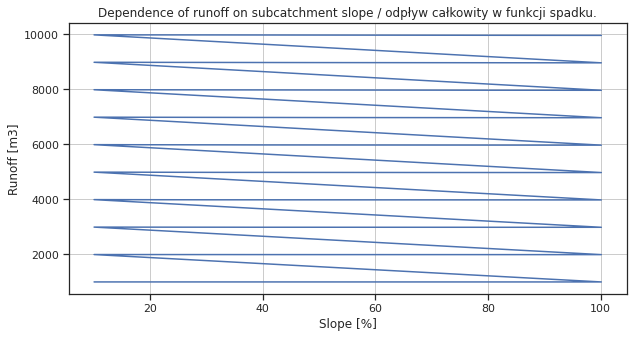

In [162]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

## Dependence of peak runoff rate on subcatchment slope

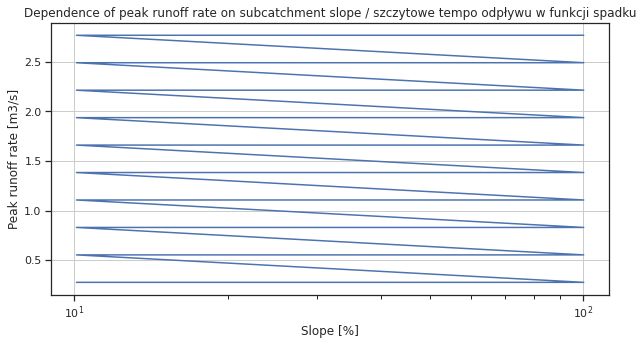

In [153]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

## Dependence of infiltration on subcatchment slope

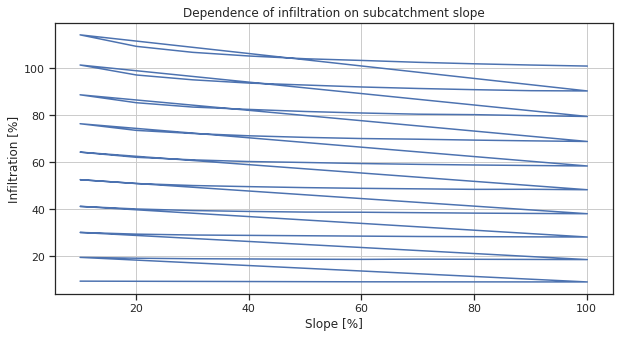

In [154]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Pipes data output

## Dependence of maximal flow on subcatchment slope.

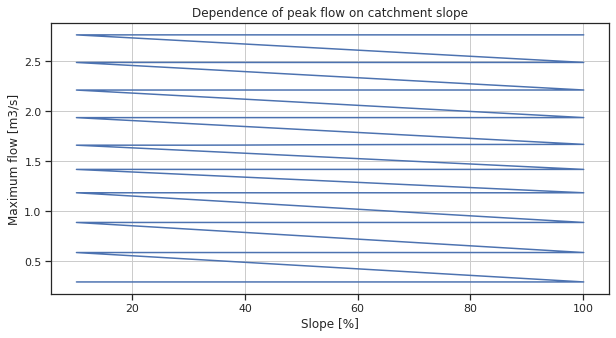

In [155]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

## Dependence of maximal velocity on subcatchment slope

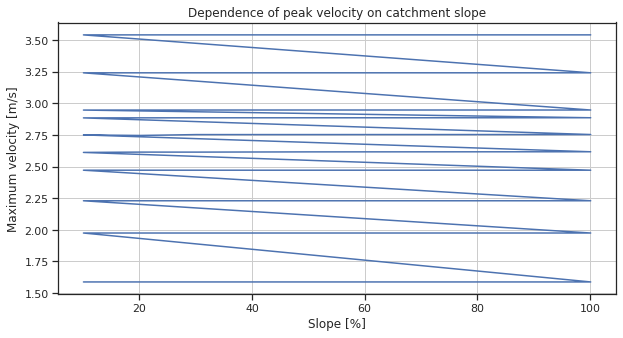

In [156]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

## Dependence of maximal pipe filling on subcatchment slope.

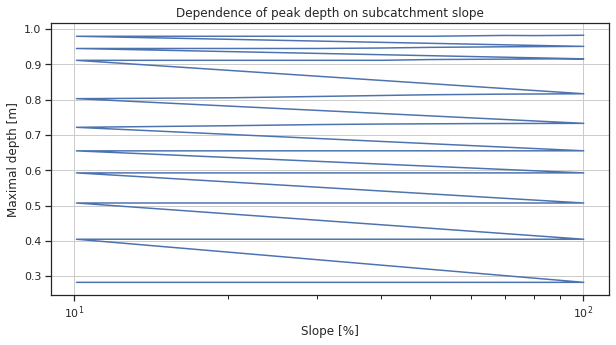

In [157]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Show correlations betwen features as heatmap

## Prepare dataframe with selected features

In [158]:
df_corr = pd.DataFrame()
# df_corr[['slope', 'runoff', 'peak_runoff_rate', 'infiltration', 'peak_flow', 'peak_velocity', 'peak_depth']] = df[['peak_depth', 'slope', 'runoff', 'peak_runoff_rate', 'infiltration', 'peak_flow', 'peak_velocity']]
df_corr[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']] = df[['slope', 'runoff', 'peak_runoff_rate', 'infiltration']]
df_corr.head()

,slope,runoff,peak_runoff_rate,infiltration
0,10.1,992.275502,0.276624,9.415028
1,10.1,992.275502,0.276624,9.415028
2,10.1,992.275502,0.276624,9.415028
3,10.1,992.275502,0.276624,9.415028
4,10.1,992.275502,0.276624,9.415028


In [159]:
corr = df_corr.corr()

## Plot heatmap

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


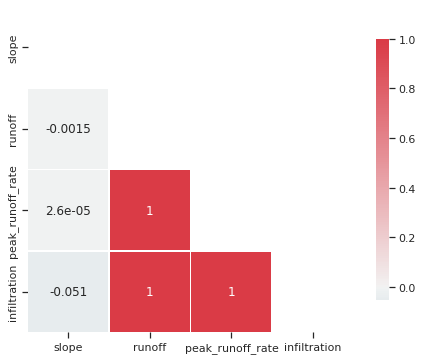

In [160]:
import seaborn as sns

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

In [161]:
!jupyter nbconvert --to pdf /content/KNN.ipynb

[NbConvertApp] WARNING | pattern '/content/KNN.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  